In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Stacy's code starts here

In [4]:
# Load naturalization table
nat_file = 'fy2018_naturalization.xlsx'
filepath = os.path.join('.', 'Resources', nat_file)

naturalization = pd.read_excel(filepath, header=5)

In [5]:
# Drop notes data at end of document
naturalization.drop(labels=range(112,118), inplace=True)
naturalization.tail()

,Year,filed,Total,Civilian,Military 2,Not reported,denied
107,2014,773824.0,653416.0,642431.0,7468.0,3517,66767.0
108,2015,783062.0,730259.0,720645.0,7234.0,2380,75810.0
109,2016,972151.0,753060.0,742090.0,8885.0,2085,86033.0
110,2017,986851.0,707265.0,695718.0,6883.0,4664,83176.0
111,2018,810548.0,761901.0,750771.0,4495.0,6635,92586.0


In [6]:
# Rename columns
naturalization.rename(columns={
    'filed': 'Petitions filed',
    'Total': 'Naturalized, total',
    'denied': 'Petitions denied'
}, inplace=True)

# Drop unneeded columns
naturalization = naturalization.drop(labels=['Civilian', 'Military 2', 'Not reported'], axis='columns')

In [7]:
# Find funny/footnoted years and fix them
for index, row in naturalization.iterrows():
    
    year = naturalization.loc[index, 'Year']
    
    if len(str(year)) > 4:
        year = int(year[0:5])
        naturalization.loc[index, 'Year'] = year
    else:
        pass

# Set year as index
naturalization.set_index(keys=['Year'], inplace=True)

In [8]:
# Change datatype to int for all columns
for c in naturalization.columns:
    naturalization[c] = naturalization[c].astype('int')

In [9]:
naturalization.head()

,Petitions filed,"Naturalized, total",Petitions denied
Year,,,
1907,21113,7941,250
1908,44032,25975,3330
1909,43141,38374,6341
1910,55750,39448,7781
1911,74740,56683,9017


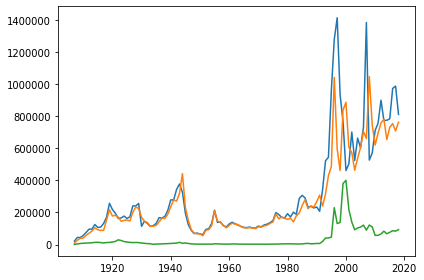

In [10]:
# Plot the data
plt.plot(naturalization.index, naturalization[['Petitions filed', 'Naturalized, total', 'Petitions denied']])
plt.tight_layout()

# Spike in 1996 - and general increase - can be explained by this bill: https://www.vox.com/2016/4/28/11515132/iirira-clinton-immigration
# Need to plot just the 2000 - 2010, then 2015 - 2018 data - to examine whether there are trends

In [86]:
# Load asylum seeker age/gender/etc table (2018)
asy_2018_file = 'fy2018_table18d_asylum_age_etc.xlsx'
filepath = os.path.join('.', 'Resources', asy_2018_file)

asylum_2018 = pd.read_excel(filepath, header=4)

In [87]:
asylum_2018.tail(10)

,Characteristic,Total,Unnamed: 2,Spouses,Children
28,Total,25439.0,16927,3636,4876
29,Married,10142.0,6506,3636,-
30,Single,14154.0,9278,-,4876
31,Widowed,232.0,232,-,-
32,Divorced/separated,896.0,896,-,-
33,Unknown,15.0,15,-,-
34,D Data withheld to limit disclosure.,NaN,NaN,NaN,NaN
35,- Represents zero.,NaN,NaN,NaN,NaN
36,Note: Data not available for individuals grant...,NaN,NaN,NaN,NaN
37,Source: U.S. Department of Homeland Security.,NaN,NaN,NaN,NaN


In [88]:
# Drop notes data at end of document
asylum_2018.drop(labels=range(34,38), inplace=True)
asylum_2018.tail()

,Characteristic,Total,Unnamed: 2,Spouses,Children
29,Married,10142.0,6506,3636,-
30,Single,14154.0,9278,-,4876
31,Widowed,232.0,232,-,-
32,Divorced/separated,896.0,896,-,-
33,Unknown,15.0,15,-,-


In [89]:
# Split into sex [5:8], rename column
asylum_2018_sex = asylum_2018.iloc[1:4,0:2]
asylum_2018_sex.rename(columns={
    "Characteristic": "Sex"
}, inplace=True)

In [90]:
# Drop unneeded rows and reset index
asylum_2018_sex.set_index(keys='Sex', inplace=True)
asylum_2018_sex

,Total
Sex,
Total,25439.0
Female,12483.0
Male,12956.0


In [91]:
# Split out broad age group [27:31]
asylum_2018_broad_age = asylum_2018.iloc[22:27,0:2]
asylum_2018_broad_age_total = asylum_2018_broad_age.drop([22])
asylum_2018_broad_age_total.rename(columns={
    "Characteristic": "Age"
}, inplace=True)
asylum_2018_broad_age_total.set_index(keys='Age', inplace=True)
asylum_2018_broad_age_total

,Total
Age,
Total,25439.0
Under 16 years,4837.0
16 to 20 years,3278.0
21 years and over,17324.0


In [92]:
# Split out marital status [32:38]

In [93]:
asylum_2018_marital = asylum_2018.iloc[28:34,0:2]
asylum_2018_marital.rename(columns={
    "Characteristic": "Marital Status"
}, inplace=True)
asylum_2018_marital.set_index(keys='Marital Status', inplace=True)
asylum_2018_marital

,Total
Marital Status,
Total,25439.0
Married,10142.0
Single,14154.0
Widowed,232.0
Divorced/separated,896.0
Unknown,15.0


In [ ]:
# Stacy's code ends here

In [ ]:
# Kana's code starts here

In [ ]:
# Kana's code ends here

In [ ]:
# Satish's code starts here

In [ ]:
# Satish's code ends here

In [ ]:
# Umar's code starts here

In [ ]:
# Umar's code ends here